# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups           
Sample_170  P10451-5                    18.889
Sample_114  P05067;P05067-11;P05067-8   19.359
Sample_061  A0A075B6J9                  18.014
Sample_062  P13611;P13611-5             18.677
Sample_073  Q9NSC7                      13.934
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups        
Sample_173  F6RFD5;P60981;P60981-2   14.994
            O75781;O75781-2          15.813
Sample_157  P04080                   16.475
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.263
            A0A075B6Q5                 12.335
            A0A075B6R2                 12.856
            A0A075B6S5                 12.877
            A0A087WSY4                 13.780
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.955
            Q9UI40;Q9UI40-2            11.411
            Q9UIW2                     12.745
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.710
            Q9UP79                     12.600
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.127,15.050,16.842,19.863,15.556,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,17.029,19.067,...,15.528,15.576,13.885,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.546,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.950,17.705,17.039,16.039,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.556,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.514,15.345,17.084,18.708,14.249,19.433,12.110,11.111
Sample_207,15.739,16.877,15.469,16.898,15.281,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.263,...,16.012,15.178,13.242,15.050,16.842,19.863,13.460,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.028,19.067,16.188,...,15.528,15.576,13.377,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.280,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.486,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.854,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.901,15.345,17.084,18.708,14.249,19.433,12.343,11.637
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 429.48it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.64it/s]

100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.56it/s]

100%|██████████| 4/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.56it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.51it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.49it/s]

100%|██████████| 5/5 [00:01<00:00,  3.24it/s]

100%|██████████| 5/5 [00:01<00:00,  3.64it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.36it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.16it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.88it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.18it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.75it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.56it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.45it/s]

100%|██████████| 7/7 [00:01<00:00,  3.31it/s]

100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.25it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.62it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.00it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.53it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.32it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.19it/s]

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

100%|██████████| 8/8 [00:02<00:00,  3.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.68it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.94it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.07it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.89it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.76it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.68it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.64it/s]

100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

100%|██████████| 9/9 [00:02<00:00,  3.95it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.37it/s]

 30%|███       | 3/10 [00:00<00:01,  5.30it/s]

 40%|████      | 4/10 [00:00<00:01,  4.27it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.00it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.84it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.75it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.66it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.16it/s]

100%|██████████| 10/10 [00:02<00:00,  2.80it/s]

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.30it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.74it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.06it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.25it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.72it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.62it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.54it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.51it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.24it/s]

100%|██████████| 11/11 [00:04<00:00,  2.09it/s]

100%|██████████| 11/11 [00:04<00:00,  2.64it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:03,  3.30it/s]

 25%|██▌       | 3/12 [00:01<00:04,  2.14it/s]

 33%|███▎      | 4/12 [00:01<00:04,  1.92it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.84it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.08it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.21it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.46it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.67it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.90it/s]

100%|██████████| 12/12 [00:04<00:00,  3.02it/s]

100%|██████████| 12/12 [00:04<00:00,  2.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.78it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.45it/s]

 31%|███       | 4/13 [00:00<00:02,  3.87it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.68it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.12it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.72it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.37it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.37it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.20it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.32it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.18it/s]

100%|██████████| 13/13 [00:05<00:00,  1.89it/s]

100%|██████████| 13/13 [00:05<00:00,  2.49it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.26it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.45it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.48it/s]

 36%|███▌      | 5/14 [00:01<00:04,  2.24it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.19it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.08it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.96it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.87it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.82it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.06it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.25it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.39it/s]

100%|██████████| 14/14 [00:06<00:00,  2.52it/s]

100%|██████████| 14/14 [00:06<00:00,  2.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.98it/s]

 20%|██        | 3/15 [00:00<00:04,  2.98it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.70it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.64it/s]

 40%|████      | 6/15 [00:02<00:03,  2.72it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.76it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.71it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.66it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.67it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.37it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.23it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.19it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.02it/s]

100%|██████████| 15/15 [00:06<00:00,  2.06it/s]

100%|██████████| 15/15 [00:06<00:00,  2.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.043 0.003          0.805 0.314       0.135   
2             0.004 0.000      0.046 0.001          0.668 0.120       0.595   
3             0.004 0.000      0.047 0.001          0.762 0.081       0.745   
4             0.004 0.000      0.046 0.001          0.772 0.083       0.734   
5             0.004 0.002      0.047 0.005          0.773 0.089       0.724   
6             0.004 0.000      0.047 0.001          0.778 0.102       0.743   
7             0.004 0.000      0.048 0.004          0.808 0.085       0.844   
8             0.004 0.000      0.044 0.004          0.810 0.088       0.843   
9             0.004 0.000      0.044 0.002          0.802 0.091       0.834   
10            0.010 0.008      0.120 0.021          0.809 0.089       0.825   
11            0.006 0.005      0.066 0.031          0.816 0.082       0.837   
12            0.008 0.007      0.085 0.026          0.812 0.078       0.831   
13            0.006 0.005      0.063 0.027          0.829 0.075       0.835   
14            0.005 0.005      0.069 0.027          0.818 0.080       0.836   
15            0.007 0.005      0.079 0.032          0.816 0.079       0.838   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.223 0.132                  0.560 0.043        0.862   
2          0.123   0.621 0.100                  0.685 0.077        0.781   
3          0.095   0.750 0.071                  0.786 0.058        0.853   
4          0.099   0.748 0.070                  0.786 0.057        0.855   
5          0.102   0.742 0.073                  0.782 0.058        0.858   
6          0.098   0.755 0.075                  0.790 0.062        0.857   
7          0.094   0.821 0.064                  0.847 0.055        0.901   
8          0.089   0.821 0.063                  0.846 0.054        0.899   
9          0.102   0.813 0.072                  0.840 0.062        0.898   
10         0.106   0.812 0.073                  0.839 0.062        0.901   
11         0.094   0.823 0.070                  0.848 0.060        0.915   
12         0.086   0.818 0.064                  0.844 0.055        0.913   
13         0.086   0.830 0.068                  0.855 0.059        0.916   
14         0.094   0.823 0.068                  0.849 0.060        0.916   
15         0.094   0.824 0.070                  0.849 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.088        210.000 0.000  
2          0.078                  0.696 0.101        210.000 0.000  
3          0.060                  0.805 0.086        210.000 0.000  
4          0.061                  0.811 0.091        210.000 0.000  
5          0.060                  0.813 0.089        210.000 0.000  
6          0.056                  0.817 0.083        210.000 0.000  
7          0.049                  0.876 0.061        210.000 0.000  
8          0.049                  0.875 0.062        210.000 0.000  
9          0.050                  0.874 0.063        210.000 0.000  
10         0.050                  0.878 0.064        210.000 0.000  
11         0.049                  0.902 0.058        210.000 0.000  
12         0.050                  0.898 0.059        210.000 0.000  
13         0.048                  0.899 0.056        210.000 0.000  
14         0.049                  0.903 0.054        210.000 0.000  
15         0.050                  0.901 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 456.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.85it/s]

100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.68it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.45it/s]

100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.90it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.93it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  2.73it/s]

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.01it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.45it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.33it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.29it/s]

100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.74it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.99it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.61it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.15it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.99it/s]

100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.66it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.12it/s]

 50%|█████     | 4/8 [00:01<00:02,  1.82it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.75it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.84it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.90it/s]

100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.09it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.50it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.12it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.87it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.66it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.74it/s]

100%|██████████| 9/9 [00:04<00:00,  1.84it/s]

100%|██████████| 9/9 [00:04<00:00,  2.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.18it/s]

 30%|███       | 3/10 [00:00<00:01,  3.80it/s]

 40%|████      | 4/10 [00:01<00:01,  3.15it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.96it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.90it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.78it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.19it/s]

 90%|█████████ | 9/10 [00:03<00:00,  1.91it/s]

100%|██████████| 10/10 [00:04<00:00,  1.68it/s]

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:03,  2.70it/s]

 27%|██▋       | 3/11 [00:01<00:04,  1.98it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.05it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.29it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.42it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.49it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.21it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.01it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.92it/s]

100%|██████████| 11/11 [00:05<00:00,  2.02it/s]

100%|██████████| 11/11 [00:05<00:00,  2.14it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.60it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.44it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.96it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.36it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.89it/s]

 58%|█████▊    | 7/12 [00:03<00:03,  1.63it/s]

 67%|██████▋   | 8/12 [00:04<00:02,  1.52it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.59it/s]

 83%|████████▎ | 10/12 [00:05<00:01,  1.73it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.83it/s]

100%|██████████| 12/12 [00:06<00:00,  1.99it/s]

100%|██████████| 12/12 [00:06<00:00,  1.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.26it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.86it/s]

 31%|███       | 4/13 [00:01<00:03,  2.57it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.29it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.28it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.14it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.95it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.88it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.92it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.03it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.09it/s]

100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

100%|██████████| 13/13 [00:05<00:00,  2.19it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.65it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.81it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.46it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.50it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.38it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.01it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.97it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.87it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.74it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.65it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.64it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.71it/s]

100%|██████████| 14/14 [00:07<00:00,  1.82it/s]

100%|██████████| 14/14 [00:07<00:00,  1.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  2.83it/s]

 20%|██        | 3/15 [00:01<00:05,  2.01it/s]

 27%|██▋       | 4/15 [00:02<00:06,  1.77it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.70it/s]

 40%|████      | 6/15 [00:03<00:04,  1.89it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.05it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.19it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.19it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.16it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.79it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.67it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.78it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.80it/s]

100%|██████████| 15/15 [00:07<00:00,  1.97it/s]

100%|██████████| 15/15 [00:07<00:00,  1.94it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.078 0.025          0.000 0.000       0.000   
2             0.004 0.003      0.056 0.017          0.659 0.116       0.573   
3             0.006 0.006      0.071 0.032          0.656 0.104       0.575   
4             0.007 0.006      0.080 0.032          0.639 0.097       0.579   
5             0.006 0.006      0.080 0.031          0.738 0.096       0.673   
6             0.004 0.001      0.059 0.018          0.747 0.101       0.688   
7             0.005 0.003      0.065 0.027          0.820 0.083       0.804   
8             0.007 0.008      0.085 0.041          0.821 0.082       0.806   
9             0.008 0.008      0.087 0.033          0.806 0.088       0.797   
10            0.005 0.004      0.066 0.028          0.805 0.088       0.801   
11            0.007 0.005      0.084 0.034          0.809 0.087       0.785   
12            0.004 0.002      0.063 0.021          0.807 0.087       0.772   
13            0.008 0.008      0.083 0.030          0.800 0.086       0.774   
14            0.008 0.005      0.074 0.025          0.800 0.082       0.776   
15            0.005 0.003      0.067 0.025          0.798 0.088       0.775   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.848   
2          0.107   0.608 0.096                  0.676 0.071        0.776   
3          0.134   0.607 0.113                  0.679 0.075        0.777   
4          0.131   0.602 0.106                  0.671 0.072        0.771   
5          0.107   0.698 0.085                  0.747 0.065        0.808   
6          0.099   0.710 0.076                  0.755 0.061        0.820   
7          0.107   0.806 0.067                  0.835 0.056        0.909   
8          0.102   0.808 0.065                  0.836 0.055        0.907   
9          0.104   0.796 0.070                  0.826 0.059        0.904   
10         0.102   0.798 0.068                  0.827 0.057        0.902   
11         0.108   0.791 0.069                  0.822 0.058        0.902   
12         0.110   0.783 0.072                  0.816 0.059        0.905   
13         0.108   0.781 0.071                  0.814 0.058        0.902   
14         0.113   0.782 0.071                  0.815 0.058        0.903   
15         0.111   0.780 0.071                  0.813 0.059        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.820 0.088        210.000 0.000  
2          0.069                  0.727 0.098        210.000 0.000  
3          0.063                  0.730 0.091        210.000 0.000  
4          0.064                  0.728 0.089        210.000 0.000  
5          0.059                  0.776 0.070        210.000 0.000  
6          0.062                  0.784 0.081        210.000 0.000  
7          0.046                  0.884 0.054        210.000 0.000  
8          0.045                  0.881 0.057        210.000 0.000  
9          0.047                  0.878 0.056        210.000 0.000  
10         0.050                  0.876 0.058        210.000 0.000  
11         0.047                  0.878 0.054        210.000 0.000  
12         0.048                  0.880 0.055        210.000 0.000  
13         0.048                  0.877 0.055        210.000 0.000  
14         0.049                  0.880 0.055        210.000 0.000  
15         0.047                  0.882 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1004.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 17.52it/s]

100%|██████████| 3/3 [00:00<00:00, 11.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 15.33it/s]

100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

100%|██████████| 4/4 [00:00<00:00, 11.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.88it/s]

100%|██████████| 5/5 [00:00<00:00, 14.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 15.87it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.50it/s]

100%|██████████| 6/6 [00:00<00:00, 14.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 15.52it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.00it/s]

100%|██████████| 7/7 [00:00<00:00, 11.01it/s]

100%|██████████| 7/7 [00:00<00:00, 11.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.17it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 13.23it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.06it/s]

100%|██████████| 8/8 [00:00<00:00, 13.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 17.52it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.49it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.01it/s]

100%|██████████| 9/9 [00:00<00:00, 12.91it/s]

100%|██████████| 9/9 [00:00<00:00, 13.41it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 15.92it/s]

 40%|████      | 4/10 [00:00<00:00, 10.54it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.86it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.02it/s]

100%|██████████| 10/10 [00:00<00:00, 10.94it/s]

100%|██████████| 10/10 [00:00<00:00, 10.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 17.87it/s]

 36%|███▋      | 4/11 [00:00<00:00, 13.02it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 11.10it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.54it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.57it/s]

100%|██████████| 11/11 [00:00<00:00, 11.20it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 18.56it/s]

 33%|███▎      | 4/12 [00:00<00:00, 11.67it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.30it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.20it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 11.35it/s]

100%|██████████| 12/12 [00:01<00:00,  9.80it/s]

100%|██████████| 12/12 [00:01<00:00, 10.55it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.08it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.72it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.22it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 12.47it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.65it/s]

100%|██████████| 13/13 [00:00<00:00, 13.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 14.20it/s]

 36%|███▌      | 5/14 [00:00<00:00, 11.35it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.58it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.33it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.00it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 10.43it/s]

100%|██████████| 14/14 [00:01<00:00, 10.82it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 18.02it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.36it/s]

 47%|████▋     | 7/15 [00:00<00:00, 12.44it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.99it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.33it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.08it/s]

100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

100%|██████████| 15/15 [00:01<00:00, 12.22it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.075 0.031          0.000 0.000       0.000   
2             0.005 0.004      0.059 0.020          0.586 0.101       0.383   
3             0.006 0.005      0.081 0.034          0.564 0.112       0.364   
4             0.005 0.004      0.062 0.024          0.561 0.103       0.417   
5             0.007 0.005      0.086 0.033          0.558 0.098       0.416   
6             0.006 0.005      0.080 0.034          0.548 0.107       0.402   
7             0.009 0.008      0.091 0.044          0.673 0.093       0.607   
8             0.006 0.005      0.078 0.037          0.672 0.090       0.606   
9             0.007 0.006      0.098 0.047          0.656 0.096       0.605   
10            0.007 0.006      0.077 0.031          0.647 0.099       0.609   
11            0.006 0.005      0.096 0.041          0.675 0.107       0.609   
12            0.010 0.009      0.082 0.037          0.676 0.107       0.605   
13            0.008 0.007      0.089 0.032          0.674 0.094       0.626   
14            0.007 0.006      0.080 0.036          0.663 0.094       0.614   
15            0.005 0.004      0.060 0.022          0.643 0.088       0.603   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.718   
2          0.105   0.456 0.096                  0.592 0.058        0.657   
3          0.111   0.434 0.104                  0.579 0.060        0.651   
4          0.114   0.472 0.101                  0.590 0.065        0.647   
5          0.105   0.470 0.092                  0.587 0.059        0.642   
6          0.118   0.458 0.109                  0.581 0.068        0.645   
7          0.110   0.633 0.087                  0.695 0.066        0.772   
8          0.110   0.632 0.087                  0.694 0.065        0.767   
9          0.124   0.623 0.094                  0.685 0.071        0.763   
10         0.114   0.621 0.089                  0.681 0.069        0.769   
11         0.110   0.633 0.085                  0.693 0.067        0.772   
12         0.107   0.631 0.084                  0.692 0.066        0.769   
13         0.101   0.643 0.077                  0.700 0.062        0.773   
14         0.102   0.633 0.080                  0.691 0.064        0.769   
15         0.102   0.617 0.080                  0.677 0.064        0.766   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.670 0.090        210.000 0.000  
2          0.082                  0.620 0.091        210.000 0.000  
3          0.079                  0.606 0.090        210.000 0.000  
4          0.076                  0.607 0.083        210.000 0.000  
5          0.079                  0.604 0.082        210.000 0.000  
6          0.075                  0.601 0.085        210.000 0.000  
7          0.072                  0.743 0.078        210.000 0.000  
8          0.074                  0.736 0.083        210.000 0.000  
9          0.075                  0.731 0.084        210.000 0.000  
10         0.075                  0.738 0.086        210.000 0.000  
11         0.073                  0.735 0.089        210.000 0.000  
12         0.074                  0.729 0.090        210.000 0.000  
13         0.072                  0.728 0.089        210.000 0.000  
14         0.073                  0.724 0.090        210.000 0.000  
15         0.072                  0.725 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,10,9,12
score_time,10,9,9
test_precision,13,8,12
test_recall,7,8,13
test_f1,13,8,13
test_balanced_accuracy,13,8,13
test_roc_auc,14,7,13
test_average_precision,14,7,7
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.50it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.06it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.92it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.96it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

100%|██████████| 7/7 [00:02<00:00,  3.08it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.84it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.75it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.94it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.25it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.91it/s]

100%|██████████| 13/13 [00:01<00:00, 12.36it/s]

100%|██████████| 13/13 [00:01<00:00, 12.65it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.01it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.25it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.81it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.13it/s]

 43%|████▎     | 6/14 [00:01<00:03,  2.65it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.71it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.74it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.86it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.97it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.08it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.03it/s]

100%|██████████| 14/14 [00:04<00:00,  3.13it/s]

100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


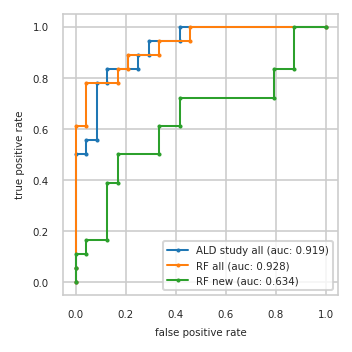

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.500  0.000 0.611  0.000 0.111
3          0.042 0.500  0.042 0.611  0.042 0.111
4          0.042 0.556  0.042 0.778  0.042 0.167
5          0.083 0.556  0.167 0.778  0.125 0.167
6          0.083 0.778  0.167 0.833  0.125 0.389
7          0.125 0.778  0.208 0.833  0.167 0.389
8          0.125 0.833  0.208 0.889  0.167 0.500
9          0.250 0.833  0.333 0.889  0.333 0.500
10         0.250 0.889  0.333 0.944  0.333 0.611
11         0.292 0.889  0.458 0.944  0.417 0.611
12         0.292 0.944  0.458 1.000  0.417 0.722
13         0.417 0.944  1.000 1.000  0.792 0.722
14         0.417 1.000    NaN   NaN  0.792 0.833
15         1.000 1.000    NaN   NaN  0.875 0.833
16           NaN   NaN    NaN   NaN  0.875 1.000
17           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,I3L3R5,Q12841;Q12841-2,Q16799
2,Q15782;Q15782-6,P10636-2;P10636-6,P30048;P30048-2
3,P04075,P08670,A0A0J9YW36;Q9NZ72;Q9NZ72-2
4,P61981,P14174,P31321
5,P14174,P04075,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,P61981,A0A075B7B8
7,Q6EMK4,None,Q9NUQ9
8,P00338;P00338-3,None,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


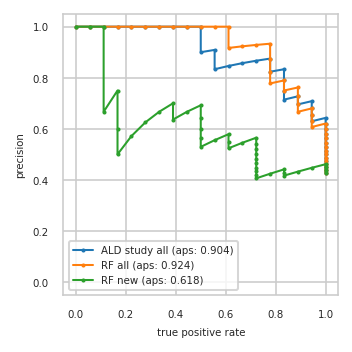

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.432 0.889
6          0.500 1.000     0.500 1.000     0.417 0.833
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.424 0.778
10         0.562 1.000     0.562 1.000     0.406 0.722
11         0.581 1.000     0.581 1.000     0.419 0.722
12         0.600 1.000     0.600 1.000     0.433 0.722
13         0.621 1.000     0.621 1.000     0.448 0.722
14         0.643 1.000     0.607 0.944     0.464 0.722
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.654 0.944     0.654 0.944     0.500 0.722
17         0.680 0.944     0.680 0.944     0.520 0.722
18         0.708 0.944     0.667 0.889     0.542 0.722
19         0.696 0.889     0.696 0.889     0.565 0.722
20         0.727 0.889     0.727 0.889     0.545 0.667
21         0.714 0.833     0.762 0.889     0.524 0.611
22         0.750 0.833     0.750 0.833     0.550 0.611
23         0.789 0.833     0.789 0.833     0.579 0.611
24         0.833 0.833     0.778 0.778     0.556 0.556
25         0.824 0.778     0.824 0.778     0.529 0.500
26         0.875 0.778     0.875 0.778     0.562 0.500
27         0.867 0.722     0.933 0.778     0.600 0.500
28         0.857 0.667     0.929 0.722     0.643 0.500
29         0.846 0.611     0.923 0.667     0.692 0.500
30         0.833 0.556     0.917 0.611     0.667 0.444
31         0.909 0.556     1.000 0.611     0.636 0.389
32         0.900 0.500     1.000 0.556     0.700 0.389
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


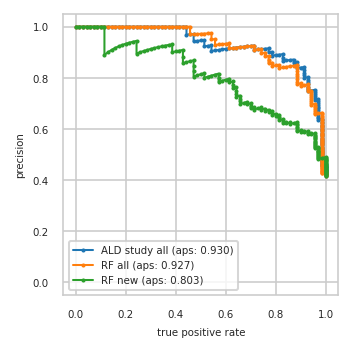

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


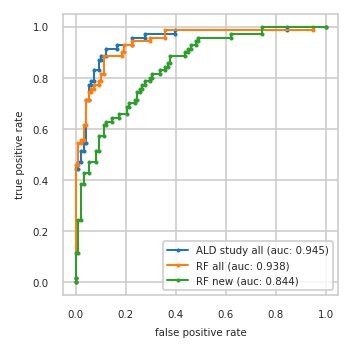

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}